# 3D Beam Profile Optomization using Genetic Algorithm

### This notebook looks to use a Genetic Algorithm to achieve an optimally flat beam profile using the beam profile of the [NSPW345CS LED](https://www.alldatasheet.com/datasheet-pdf/pdf/240328/NICHIA/NSPW345CS.html?) from Nichia Corp.

### The Genetic Algorithm desgined has been adapted from an online source which uses a genetic algorithm to solve the "travelling salesman problem" which can be found at [Traveling Salesman Problem](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import csv , warnings
from Cosine_Power_Model import model_fit , model_param , I_calc_cos2 , RMSE
import time
import random
import operator
import pandas as pd

Import Relevant Python Libaries

In [2]:
datasheet = 'Nichia.csv'
file = csv.reader(open(datasheet))  #read in relevant datasheet
angle = np.linspace(-90 , 90 , 181)
theta = angle*np.pi/180
data = []
x_axis = []
x_axis_rad = []
y_axis = []
Power = []

for row in file:
    data.append([float(row[0]),float(row[1])])

data.sort(key = lambda x: x[0])  #sorts the array in ascending order

for item in data :
    x_axis_rad.append(item[0]*np.pi/180) #converts to radians
    x_axis.append(item[0])
    y_axis.append(item[1])
    
    
"Specifying the boundary will affect the accuracy of the model."
"It is easiest to start with a relatively low accuracy and refine the boundary accoringly"
bound = [[.1 , [1 , 1] , [0 ,0] , [0 , 10]] , [.02,[0,.2] , [45 , 90] , [0 , 200]] , [.02, [0 , 0.2] , [0 ,45] , [0 , 200]] , [.015,[0 , 0.2] , [0 ,90] , [0 , 200]]]

Power , Error , Param = model_fit(x_axis , y_axis , .017 , bound)

RMSE: 0.050641298624668915
R-squared: 0.981117696041258

RMSE: 0.019073100008894953
R-squared: 0.9972776809885643

RMSE: 0.019073100008894953
R-squared: 0.9972776809885643

RMSE: 0.01536714308676109
R-squared: 0.9980652526620926



Model the Beam Profile of the Nichia LED using the modelling algorithm designed in "Sintec-Model"

In [3]:
c1 , c2 ,c3 = model_param(Param)
ModelPrediction = I_calc_cos2(theta , c1 , c2 , c3 )

Store the parameters in local variables c1 ,c2 , c3 and the modelled beam profile in ModelPrediction

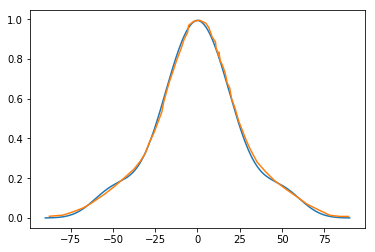

In [4]:
plt.plot(angle , ModelPrediction)
plt.plot(x_axis , y_axis)

Comparison of modelled profile and actual profile

In [54]:
angle = np.linspace(-70 , 70 , 45)
theta = angle*np.pi/180
axis_x = axis_y = np.tan(theta)
X_axis , Y_axis = np.meshgrid(axis_x , axis_y)

Setting up the allowable workspace range. The angle is a linear range of values between -80 and 80 degees. After being converted to radians and the tan of each angle is found the overall workspace is -5.6 and 5.6 normalized units. 

np.meshgrid converts axis_x and axis_y into a 5.6 x 5.6 3D cartesian plane

In [55]:
def I_calc_cos2(x , c1 , c2 , c3) :
    Power = []
    x = np.array(x)
    c2_rad = np.array(c2)*np.pi/180 #convert to radians as numpy takes radians    
    I = np.zeros(len(x))
    for i in range(min(len(c1),3)) : 
        I += np.array(c1[i]*(np.cos(abs(x) - c2_rad[i])**c3[i]))

    if len(c1) == 4 :
        I = I -  np.array(c1[3]*(np.cos(abs(x) - c2_rad[3])**c3[3]))     
        
    return I

Uses the beam profile parameters to return the beam profile at each angle x

In [111]:
def RMSE(absError) : 
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE

    return RMSE

In [56]:
def profile_adjustment(origin_x , origin_y , source_dis) :
    Z = []
    for i in range(len(X_axis)) :
        angle_xy = []
        for a , b in zip(X_axis[i] , Y_axis[i]) :
            dis_from_origin = (np.sqrt((a - origin_x)**2 + (b - origin_y)**2))
            angle_xy.append(np.arctan(dis_from_origin/(1+source_dis)))
        Z.append(np.array(I_calc_cos2(angle_xy , c1 , c2 ,c3))/(1+source_dis)**2)
        
    return np.array(Z)

Adjusts the normalized Beam Profile value depending on the distance of the point from the origin and the distance of the measurement plane from the source. This code uses the X-Y coordinate plane established earlier

The code below was adjusted from the webpage [towarddatascience.com](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) which outlines how a genetic algorithm can be used to optomize the path  of a car salesman to several cities , where he visits each city only once

In [345]:
class Params :
    
    def __init__(self , origin_x , origin_y , source_dis) :
        self.origin_x = np.array(origin_x)
        self.origin_y = np.array(origin_y)
        self.source_dis = source_dis
        
    def distance(self) :
        Beam_Profile = np.array([np.zeros(45) for i in range(45)])
        for item1 , item2 in zip(self.origin_x , self.origin_y) :
            Beam_Profile += profile_adjustment(item1 , item2 , self.source_dis)
        
        absError = abs(target_profile - Beam_Profile)
        distance = np.sum(absError)
        
        return distance
    
    def __repr__(self):
        return "(" + str(self.origin_x) + "," + str(self.origin_y) +  "," + str(self.source_dis) + ")"
        

Classifying the parameters over which the genetic algorithm intends to optomize. origin_x and origin_y at which the LED's can be placed and source_dis is the distance away at which the LED's will be measured

Params.distance() is a function which gives a score based on how low the variance of the beam profile is. The lower the value of the distance the flatter the beam profile is in theory. Ideally you would select a range over which you wish to achieve a optimally flat response, thus this distance funciton could be altered to target a specific section of the 2D cartesian plane over which you want an optimally flat response. Best way to do this would be to identify a target and use a RMSE between the two. Alternatively minimize the variation between the Beam_Profile and the target. 

In [235]:
class Fitness :
    
    def __init__(self , profile) :
        self.profile = profile
        self.fitness = 0.0
        
    def profiledistance(self) :
        if self.distance == 0 :
            beam_profile = self.profile
            pathdistance = beam_profile.distance()
            
        self.distance = pathdistance
        
        return self.distance
    
    def profilefitness(self) :
        if self.fitness == 0 :
            self.fitness = 1 / float(self.profile.distance())
            
        return self.fitness

This class describes the fitness of each Param in the population. The gentic Algorithm maximizes the fittest function, hence it is the inverse of the variation described above that is taken

In [339]:
def initialPopulation(popSize):
    population = []

    for i in range(0, popSize):
        source_dis = random.uniform(0 , 1)
        population.append(Params(origin_x= [random.uniform(-1.2 , 1.2) for i in range(4)] , 
                                 origin_y= [random.uniform(-1.2 , 1.2) for i in range(4)],
                                 source_dis= source_dis))
    return population

This function describes the initial population over which the genetic algorthim will search. Note the source distance is constant for each LED in a single set of the population. The source distance chosen is always the extremity, however the larger the source distance the less the power. For this reason this parameter could be removed and replaced with a sum which calculates the correct source distance for a required power. 

i.e. if a normalized power of 0.5 is required, the source distance should be selected as   

$0.5 = max($Modelled_Beam_Profile$)/d^2$  

assuming max($Modelled_Beam_Profile$) = 1  

$d^2 = 1/0.5$  

$d^2 = 2 $  

$d = \sqrt{2} $  

$(1 + $source_dis$) = \sqrt{2} $  

source_dis $ = \sqrt{2} - 1 $  

source_dis $ \approx 0.414 $  

In [237]:
def rankParams(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).profilefitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Ranks the models based on their fitness values. Parameter values are stored using the Params class

In [238]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

The fittest parameters are automatically selected up to and including the length of the elitesize variable. The other values are selected randomly from the group

In [239]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

This function selects all selected parameters from the selection function.

In [240]:
def breed(parent1, parent2):
    child = []

    geneA = random.randint(1,3)
    if geneA == 1 :
        child.append(Params(parent1.origin_x , parent2.origin_y , parent2.source_dis))
    elif geneA == 2 :
        child.append(Params(parent2.origin_x , parent1.origin_y , parent2.source_dis))
    else :
        child.append(Params(parent2.origin_x , parent2.origin_y , parent1.source_dis))
    return child

This funciton is used to crossover two chormosones together based on a random integer between 1 and 3. Crossover occurs between the origin_x , origin_y or source_dis parameter of parent1 and the other two parameters of parent 2. e.g. if the random integer is 2 , the new chromosone would consist of origin_x and source_dis from parent 2 and origin_y from parent2

In [241]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[0])
    return children

Ensures the fittest parameters are automatically selected and then performs crossover between the ith and ith+1 element starting from the fittest and ending at the length of the population minus the elitesize

In [340]:
def mutate(individual, mutationRate):

    if(random.random() < mutationRate):
        chance = random.randint(1,3)
        if chance == 1 :
            individual.origin_x =  np.array([random.uniform(-1.2 , 1.2) for i in range(4)])
        elif chance == 2 :
            individual.origin_y = np.array([random.uniform(-1.2 , 1.2) for i in range(4)])
        else :
            individual.source_dis = random.uniform(0 , 1)
            
    return individual

Introduces mutatation into the population if a sample is lower than the mutation rate

In [341]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Executes the mutate function for the entire set of the population

In [342]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankParams(currentGen)
    progress = 1/popRanked[0][1]
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration , progress

Executes the above funcitons so that they can be performed iteratively without the need for excess coding

In [343]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize)
    progress = []
    err = 1 / rankParams(pop)[0][1]
    progress.append(err)
    print("Initial Variance: " + str(err) + "\n")
    
    for i in range(0, generations):
        start = time.time()
        pop , err = nextGeneration(pop, eliteSize, mutationRate)
        end = time.time()
        time_update = end - start
        mins = int(str(((time_update*generations)-(time_update*(i+1)))/60).partition(".")[0])
        secs = ((time_update*generations)-(time_update*(i+1)))%60
        progress.append(err)
        print("Approx {:3} minutes {:2.3} seconds remaining".format(mins , secs), end="\r")
    
    Final = rankParams(pop)[0]
    print("\n")
    print("Final Variance: " + str((1 / Final[1])))
    bestprofileIndex = Final[0]
    bestprofile = pop[bestprofileIndex]
    return bestprofile , progress

Ties all the previous funcitons into one package and prints stating and finishing error as well as keeping track of the approximate time to completion

In [ ]:
target_profile = target(1)
bestprofile , progress = geneticAlgorithm(popSize=100 , eliteSize=10 , mutationRate=0.1 , generations= 20)

Initial Variance: 559.4604084592711



In [287]:
def target(power) :
    Z = []
    for i in range(len(X_axis)) :
        Z_temp = []
        for a , b in zip(X_axis[i] , Y_axis[i]) :
            if -1 < a < 1 and -1 < b < 1 :
                Z_temp.append(power)
            else :
                Z_temp.append(0)
        Z.append(Z_temp)
        
    return np.array(Z)

Function which creates the target as a flat top cube of variable height

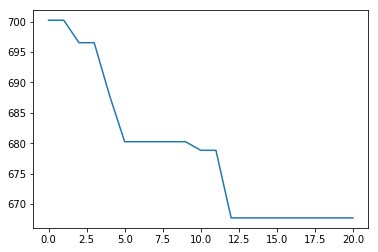

In [333]:
plt.plot(progress)

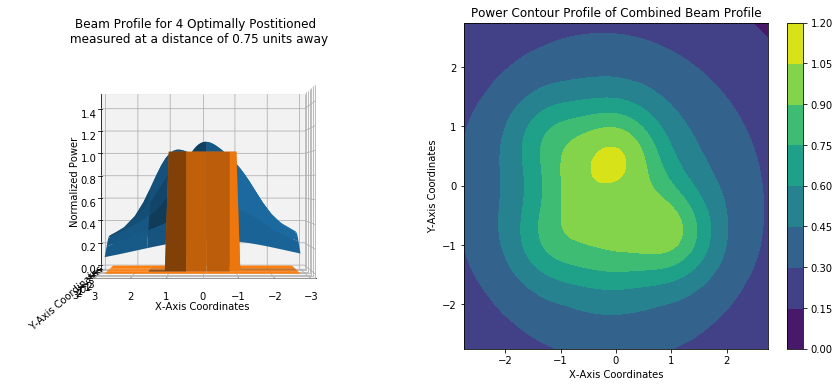

In [334]:
variance = []
peak_intensity = []
Beam_Profile = np.array([np.zeros(45) for i in range(45)])
for item1 , item2 in zip(bestprofile.origin_x , bestprofile.origin_y) :
    Beam_Profile += np.array(profile_adjustment(item1 , item2 , bestprofile.source_dis))
    
max_val = max([max(item) for item in Beam_Profile])
peak_intensity.append(max_val)
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_axis, Y_axis, Beam_Profile, rstride=10, cstride=10 )
ax1.plot_surface(X_axis, Y_axis, target(1), rstride=10, cstride=10 )
ax1.set_xlabel("X-Axis Coordinates")
ax1.set_ylabel("Y-Axis Coordinates")
ax1.set_zlabel("Normalized Power")
ax1.set_zlim(0,1.5)
ax1.view_init(0  , 90)
ax1.set_title("Beam Profile for 4 Optimally Postitioned \n measured at a distance of %1.2f units away" % bestprofile.source_dis)
ax2 = fig.add_subplot(122)
ax2.set_title("Power Contour Profile of Combined Beam Profile")
cf = ax2.contourf(X_axis , Y_axis , Beam_Profile)
ax2.set_xlabel("X-Axis Coordinates")
ax2.set_ylabel("Y-Axis Coordinates")
#ax2.set_xlim(-1,1)
#ax2.set_ylim(-1,1)
cbar = plt.colorbar(cf)
plt.show()

At a distance away of 0.749


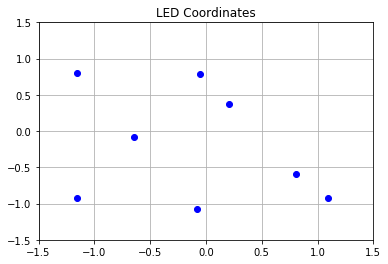

In [335]:
for item1 , item2 in zip(bestprofile.origin_x , bestprofile.origin_y) :
    plt.scatter(item1 , item2 , color = 'b')
    
plt.title("LED Coordinates")
plt.grid()
plt.xlim(-1.5 , 1.5)
plt.ylim(-1.5 , 1.5)
print("At a distance away of %1.3f" % bestprofile.source_dis)
